# UMAP analysis of patch embeddings

This notebook computes 2D UMAP embeddings for a set of 3D patches across multiple pretrained feature models.

Usage:
- Fill `PATCH_LIST` with tuples `(case_filename, (d,h,w))` and set `PRETRAINED_MODELS` to paths or model folders to evaluate.
- Run the cells top-to-bottom. The notebook loads each model sequentially to conserve GPU memory.
- Outputs: one UMAP scatter per model (over patches) and a grid of patch middle-slices with a legend of model colors.

In [6]:
# Imports and configuration
import sys
import json
import subprocess
import importlib
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA

# try import umap-learn
try:
    import umap
except Exception:
    print('umap not found, attempting to install umap-learn...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'umap-learn'])
    importlib.invalidate_caches()
    import umap

print('torch:', torch.__version__)
print('umap:', umap.__version__)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Defaults
DEFAULT_PATCH_SIZE = (32, 160, 128)  # (D,H,W)
ROOT_DIR = Path('/nfs/erelab001/shared/Computational_Group/Naravich')
DATASETS_DIR = ROOT_DIR / 'datasets' / 'nnUNet_Datasets'
IMAGES_DIR = DATASETS_DIR / 'nnUNet_preprocessed'/ 'Dataset307_Sohee_Calcium_OCT_CrossValidation' / 'nnUNetPlans_3d_fullres'
plans_file = DATASETS_DIR / "nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json"
dataset_file = DATASETS_DIR / "nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/dataset.json"
with open(dataset_file) as f:
    dataset_json = json.load(f)

# Example: user will override these two lists when using the notebook
PATCH_LIST = [
    ('101-019.npy', (162,220,155)),
    ('101-019.npy', (147,170,150)),
    ('101-019.npy', (170,270,135)),
    ('101-019.npy', (147,80,290)),
] * 16
PRETRAINED_MODELS = [
    # LaW
    (DATASETS_DIR / "nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth", "LaW"),
    # Genesis
    (ROOT_DIR / "datasets" / "ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt", "Genesis"),
    # CLIP
    (DATASETS_DIR / "../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt", "CLIP"),
    # No Pretrain
    (Path("None"), "No Pretrain"),
    # str(path_to_pretrained_checkpoint_or_model_folder),
]

torch: 2.5.1
umap: 0.5.9.post2
Device: cuda


In [7]:
# Helper functions: loading image, extracting patch, and initializing predictor
import nibabel as nib
from nnunetv2.inference.predict_from_raw_data import nnUNetPredictor
from nnunetv2.utilities.get_network_from_plans import get_network_from_plans
from nnunetv2.run.load_pretrained_weights import load_pretrained_weights
from nnunetv2.utilities.plans_handling.plans_handler import PlansManager
from nnunetv2.utilities.label_handling.label_handling import determine_num_input_channels
import torch

def find_case_file(image_dir: Path, case_name: str):
    p = Path(image_dir) / case_name
    if p.exists():
        return p
    # try to find by pattern
    files = list(p.parent.rglob(case_name)) if p.parent.exists() else []
    if files:
        return files[0]
    raise FileNotFoundError(f'Case file {case_name} not found under {image_dir}')

def load_case_array(case_file: Path):
    if case_file.suffix == '.npz':
        arr = np.load(case_file)
        # heuristics for key
        for k in ('data','x','arr_0','image','images'):
            if k in arr:
                return arr[k]  # may be C,D,H,W or D,H,W
        return arr[list(arr.files)[0]]
    elif case_file.suffix == '.npy':
        return np.load(case_file)
    else:
        img = nib.load(str(case_file))
        return img.get_fdata()

def ensure_4d_CDHW(x: np.ndarray):
    # convert to (C,D,H,W)
    if x.ndim == 3:
        return np.expand_dims(x, 0)
    if x.ndim == 4:
        # ambiguous: could be (B,C,D,H,W) or (C,D,H,W) - we assume (C,D,H,W)
        return x
    if x.ndim == 5:
        return x[0]
    raise ValueError(f'Unexpected image array shape: {x.shape}')

def extract_patch_from_array(arr: np.ndarray, offset: tuple, patch_size: tuple):
    # arr: (C,D,H,W)
    C, D, H, W = arr.shape
    d0 = int(np.clip(offset[0], 0, D - patch_size[0]))
    h0 = int(np.clip(offset[1], 0, H - patch_size[1]))
    w0 = int(np.clip(offset[2], 0, W - patch_size[2]))
    d1, h1, w1 = d0 + patch_size[0], h0 + patch_size[1], w0 + patch_size[2]
    patch = arr[:, d0:d1, h0:h1, w0:w1].copy()
    return patch, (d0, h0, w0)

def initialize_untrained_predictor(predictor, plans_file):
    """Initialize predictor with an untrained model based on plans file.
    def initialize_untrained_predictor(predictor, plans_file):
    Args:
        predictor: nnUNetPredictor instance
        plans_file: Path to the plans.json file
    """
    # Load network from plans
    plans_file = Path(plans_file)
    if not plans_file.exists():
        raise FileNotFoundError(f"Plans file not found: {plans_file}")
    
    # Load and parse plans
    with open(plans_file) as f:
        plans = json.load(f)
    
    # Initialize managers
    plans_manager = PlansManager(plans_file)
    configuration = "3d_32x160x128_b10"
    if configuration not in plans['configurations']:
        configuration = list(plans['configurations'].keys())[0]
    
    configuration_manager = plans_manager.get_configuration(configuration)
    label_manager = plans_manager.get_label_manager(dataset_json)
    num_input_channels = determine_num_input_channels(plans_manager, configuration_manager,dataset_json)
    # Get network parameters from configuration manager
    network = get_network_from_plans(
        arch_class_name=configuration_manager.network_arch_class_name,
        arch_kwargs=configuration_manager.network_arch_init_kwargs,
        arch_kwargs_req_import=configuration_manager.network_arch_init_kwargs_req_import,
        input_channels=num_input_channels,
        output_channels=label_manager.num_segmentation_heads,
        allow_init=True,
        deep_supervision=True
    )
    network.to(predictor.device)
    
    # Initialize predictor with untrained network
    predictor.network = network
    predictor.plans_manager = plans_manager
    predictor.configuration_manager = configuration_manager
    predictor.label_manager = label_manager
    predictor.plans = plans
    predictor.configuration_name = configuration
    
    print(f"Initialized untrained network from {plans_file}")
    print(f"Using configuration: {configuration}")
    print(f"Architecture: {configuration_manager.network_arch_class_name}")
    print(f"Input channels: {num_input_channels}, Output channels: {label_manager.num_segmentation_heads}")
    return predictor

def extract_activation_vector(predictor, input_tensor: torch.Tensor, target_module_name: str = None) -> np.ndarray:
    """Run forward and capture a single pooled feature vector for the target module.
    We perform global average pooling over spatial dims of the activation to get a (C,) vector.
    """
    net = predictor.network.to(DEVICE)
    activations = {}
    hooks = []

    def find_module_by_name(root, name):
        if not name:
            return None
        cur = root
        for p in name.split('.'):
            if p.isdigit():
                cur = cur[int(p)]
            else:
                cur = getattr(cur, p)
        return cur

    # select module: default to last encoder stage if available
    if target_module_name is None and hasattr(net, 'encoder'):
        enc = net.encoder
        if hasattr(enc, 'stages') and len(enc.stages) > 0:
            target = enc.stages[-1]
            target_name = 'encoder.stages.-1'
        else:
            target = enc
            target_name = 'encoder'
    elif target_module_name is not None:
        target = find_module_by_name(net, target_module_name)
        target_name = target_module_name
    else:
        target = net
        target_name = 'network'

    def hook_fn(m, inp, out):
        activations[target_name] = out.detach().cpu()

    hooks.append(target.register_forward_hook(hook_fn))
    was_training = net.training
    net.eval()
    with torch.no_grad():
        x = input_tensor.to(DEVICE).float()
        out = net(x)

    for h in hooks:
        h.remove()
    if was_training:
        net.train()

    act = activations[target_name]  # [B,C,(D,),H,W] or [B,C,H,W]
    a = act.cpu().numpy()
    # global average pool spatial dims for first batch
    if a.ndim == 5:
        # B,C,D,H,W -> pool D,H,W -> C vector
        v = a[0].mean(axis=(1,2,3))
    elif a.ndim == 4:
        # B,C,H,W -> pool H,W
        v = a[0].mean(axis=(1,2))
    else:
        raise RuntimeError('Unexpected activation rank: ' + str(a.shape))
    return v

In [8]:
# Main pipeline: compute embeddings for PATCH_LIST across PRETRAINED_MODELS and visualize
import matplotlib.patches as patches
from matplotlib import cm

def compute_embeddings_for_models(patch_list, pretrained_models, image_root, patch_size=DEFAULT_PATCH_SIZE, target_module=None):
    """Returns: dict model_path -> dict with keys 'embeddings' (N x C), 'coords' (N x 2 after UMAP), 'patches' (list of patch arrays)
    """
    results = {}
    for m_idx, model in enumerate(pretrained_models):
        pretrained_weights_file, model_name = model
        print(f'Processing model {m_idx+1}/{len(pretrained_models)}: {model}')
        predictor = nnUNetPredictor(tile_step_size=0.5, use_gaussian=True, use_mirroring=False, perform_everything_on_device=True, device=DEVICE)
        # Initialize predictor
        initialize_untrained_predictor(predictor, plans_file)
        if pretrained_weights_file.exists():
            print('Loading pretrained weights from', pretrained_weights_file)
            load_pretrained_weights(predictor.network, pretrained_weights_file)
        embeddings = []
        patches = []
        for case_name, offset in patch_list:
            case_file = find_case_file(image_root, case_name)
            arr = load_case_array(case_file)
            arr = ensure_4d_CDHW(arr)
            patch, actual_offset = extract_patch_from_array(arr, offset, patch_size)
            patches.append(patch)
            x_in = np.expand_dims(patch, 0)  # (1,C,D,H,W)
            t = torch.from_numpy(x_in).float()
            try:
                v = extract_activation_vector(predictor, t, target_module_name=target_module)
            except Exception as e:
                print('Failed to extract activation vector for', case_name, offset, ':', e)
                v = np.zeros(64)  # fallback vector
            embeddings.append(v)
        embeddings = np.stack(embeddings, axis=0)
        # reduce dimensionality (PCA) to speed up UMAP if necessary
        if embeddings.shape[1] > 64:
            print(embeddings.shape[1], 'dimensions too high, reducing to 64 with PCA before UMAP', embeddings.shape)
            p = PCA(n_components=min(64, embeddings.shape[1]))
            emb_p = p.fit_transform(embeddings)
        else:
            emb_p = embeddings
        # run UMAP to 2D
        reducer = umap.UMAP(n_components=2, random_state=0)
        coords = reducer.fit_transform(emb_p)
        results[str(model_name)] = {'embeddings': embeddings, 'coords': coords, 'patches': patches}
        # free GPU memory explicitly
        del predictor
        torch.cuda.empty_cache()
    return results

def plot_results(results, patch_list, figsize=(12,10)):
    # assign colors per model
    models = list(results.keys())
    cmap = cm.get_cmap('tab10')
    colors = {m: cmap(i % 10) for i,m in enumerate(models)}
    
    # scatter per model with embedded thumbnails
    fig, ax = plt.subplots(figsize=figsize)
    
    for m_idx, m in enumerate(models):
        coords = results[m]['coords'][:4]
        patches_list = results[m]['patches'][:4]

        ax.scatter(coords[:,0], coords[:,1], alpha=0)  # invisible but triggers autoscale

        for i, (x, y) in enumerate(coords):
            # extract middle slice thumbnail
            patch = patches_list[i]
            mid = patch.shape[1] // 2
            thumb = patch[0, mid]
            
            # normalize thumbnail for display
            thumb_norm = (thumb - thumb.min()) / (thumb.max() - thumb.min() + 1e-6)
            
            # create RGB image with colored border
            thumb_rgb = np.stack([thumb_norm]*3, axis=-1)
            border_color = np.array(colors[m][:3])
            
            # add colored border (5 pixels)
            border_width = 5
            h, w = thumb_rgb.shape[:2]
            thumb_bordered = np.ones((h + 2*border_width, w + 2*border_width, 3))
            thumb_bordered[:] = border_color
            thumb_bordered[border_width:-border_width, border_width:-border_width] = thumb_rgb
            
            # embed as annotation
            imagebox = OffsetImage(thumb_bordered, zoom=0.3, cmap='gray')
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)
    
    # add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[m], 
                              markersize=10, label=m) for m in models]
    ax.legend(handles=legend_elements, fontsize=10, loc='upper right')
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP embeddings with patch thumbnails (border color = model)')
    plt.tight_layout()
    plt.show()

In [9]:
# def plot_results(results, patch_list, figsize=(10,8)):
#     # assign colors per model
#     models = list(results.keys())
#     cmap = cm.get_cmap('tab10')
#     colors = {m: cmap(i % 10) for i,m in enumerate(models)}
#     # scatter per model (each has N points)
#     plt.figure(figsize=figsize)
#     for m in models:
#         coords = results[m]['coords']
#         plt.scatter(coords[:,0], coords[:,1], label=m, color=colors[m], s=40)
#         # annotate with patch index to link with thumbnails
#         for i,(x,y) in enumerate(coords):
#             plt.text(x, y, str(i), color='k', fontsize=8)
#     plt.legend(fontsize=8)
#     plt.title('UMAP embeddings (one point per patch)')
#     plt.show()

#     # show thumbnails in a grid and a color bar showing model colors
#     N = len(patch_list)
#     ncols = min(6, N)
#     nrows = int(np.ceil(N / ncols))
#     fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
#     axs = np.atleast_2d(axs).reshape(nrows, ncols)
#     for i, (case_name, offset) in enumerate(patch_list):
#         r = i // ncols
#         c = i % ncols
#         ax = axs[r,c]
#         patch = results[list(results.keys())[0]]['patches'][i]  # pick first model's patch (same patches)
#         # show middle depth slice
#         mid = patch.shape[1] // 2
#         ax.imshow(patch[0, mid], cmap='gray')
#         ax.axis('off')
#         ax.set_title(f'{i}: {case_name} offset={offset}')
#         # draw small color legend squares for each model under the thumbnail
#         for j,m in enumerate(models):
#             col = colors[m]
#             rect = patches.Rectangle((0.02 + 0.08*j, 0.02), 0.06, 0.06, transform=ax.transAxes, facecolor=col, edgecolor='k')
#             ax.add_patch(rect)
#     # hide empty axes
#     for i in range(N, nrows*ncols):
#         r = i // ncols
#         c = i % ncols
#         axs[r,c].axis('off')
#     plt.suptitle('Patch middle-slices with model color keys (squares)')
#     plt.show()

In [10]:
%matplotlib inline


Processing model 1/4: (PosixPath('/nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth'), 'LaW')


Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_results/Dataset300_Lumen_and_Wall_OCT/nnUNetTrainer__nnUNetPreprocessPlans__3d_fullres/fold_all/checkpoint_best.pth ###################


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

320 dimensions too high, reducing to 64 with PCA before UMAP (64, 320)


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing model 2/4: (PosixPath('/nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt'), 'Genesis')
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis

/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

320 dimensions too high, reducing to 64 with PCA before UMAP (64, 320)


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing model 3/4: (PosixPath('/nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt'), 'CLIP')
Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
Loading pretrained weights from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt
################### Loading pretrained weights from file  /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/../OpenAI-CLIP-logs/shared_projector_shared_encoder/nnunet.pt ###################


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/nnunetv2/run/load_pretrained_weights.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load(

320 dimensions too high, reducing to 64 with PCA before UMAP (64, 320)
Processing model 4/4: (PosixPath('None'), 'No Pretrain')


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Initialized untrained network from /nfs/erelab001/shared/Computational_Group/Naravich/datasets/nnUNet_Datasets/nnUNet_preprocessed/Dataset307_Sohee_Calcium_OCT_CrossValidation/nnUNetPlans.json
Using configuration: 3d_32x160x128_b10
Architecture: dynamic_network_architectures.architectures.unet.PlainConvUNet
Input channels: 1, Output channels: 2
320 dimensions too high, reducing to 64 with PCA before UMAP (64, 320)


/nfs/erelab001/shared/Computational_Group/Naravich/nnUNet/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_1496461/2603553978.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


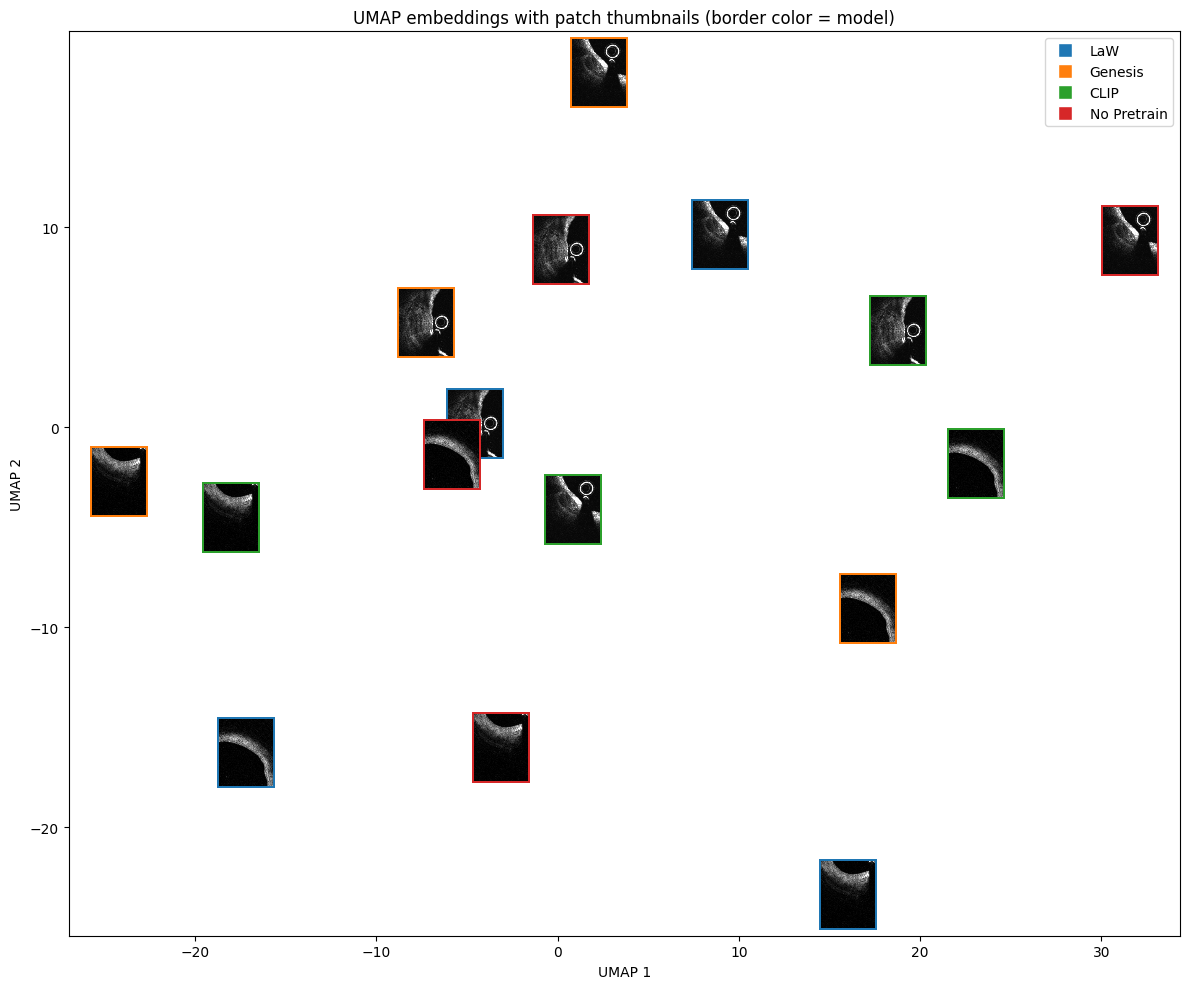

In [11]:
# Example run: user should populate PATCH_LIST and PRETRAINED_MODELS above, then run this cell.
# Example values (uncomment and edit):
# PATCH_LIST = [('101-044_0000.nii.gz', (140,150,128)), ('101-045_0000.nii.gz', (120,130,100))]
# PRETRAINED_MODELS = ['/path/to/modelA', '/path/to/modelB']

if len(PATCH_LIST) == 0:
    print('No patches provided: set PATCH_LIST and rerun the cell')
else:
    results = compute_embeddings_for_models(PATCH_LIST, PRETRAINED_MODELS, IMAGES_DIR, patch_size=DEFAULT_PATCH_SIZE)
    plot_results(results, PATCH_LIST)